<a href="https://colab.research.google.com/github/Mikeygoldman1/Group12_MBTI/blob/main/SVM_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of MBTI personality using Support Vector Machine (SVM)

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import string
import nltk
from random import sample
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import neural_network
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import warnings
from collections import Counter

!pip install plotly>=4.0.0 --quiet
import plotly.express as graph

import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/mbti_1.csv")

## Preprocessing 

In [ ]:
import re
import nltk
!pip install contractions --quiet
import contractions
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
def preprocess_1(text):
    
    # Lowering letters
    text = text.lower()
    
    # Removing urls (S+ matches all non whitespace chars)
    text = re.sub(r'http\S*', '', text)

    # Removing emails & twitter usernames
    text = re.sub('\S*@\S*', '', text)

    # Expand contractions   
    text=contractions.fix(text)
        
        
    # Removing numbers
    text = re.sub('[^a-zA-Z]',' ',text)

    # Remove MBTI type mentions from posts 
    text = re.sub(r"(intj)|(intp)|(infp)|(infj)|(istj)|(istp)|(isfp)|(isfj)|(entj)|(entp)|(enfp)|(enfj)|(estj)|(estp)|(esfp)|(esfj')", ' ', text)

    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
def preprocess_2(text):
    # Removing all whitespaces in order to join with proper whitespace
    word_tokens = word_tokenize(text)
     

    # Removing all stop words
    english_stopwords = stopwords.words('english')  
    word_tokens = [word for word in word_tokens if not word in english_stopwords] 
    
    
    # Lemmatize the text 
    lemmatizer = WordNetLemmatizer()
    word_tokens = [lemmatizer.lemmatize(word) for word in word_tokens ]

    return ' '.join(word_tokens)
    

In [ ]:
dataset['posts'] = dataset['posts'].apply(preprocess_1)
dataset['posts'] = dataset['posts'].apply(preprocess_2)

## Splitting dataset into train and test sets for each dichotomy

Split up the personality types

*   IE: I=1, E=0
*   NS: N=1, S=0
*   TF: T=1, F=0
*   JP: J=1, P=0

In [ ]:
from sklearn.model_selection import train_test_split
#IE dichotomy
Train_X,Test_X,Train_Y,Test_Y=model_selection.train_test_split(dataset['posts'],dataset['type'],test_size=0.1)

In [ ]:
IE_Train_Y=Train_Y.apply(lambda x: 1 if x[0]=='I' else 0)
NS_Train_Y=Train_Y.apply(lambda x: 1 if x[1]=='N' else 0)
TF_Train_Y=Train_Y.apply(lambda x: 1 if x[2]=='T' else 0)
JP_Train_Y=Train_Y.apply(lambda x: 1 if x[3]=='J' else 0)


IE_Test_Y=Test_Y.apply(lambda x: 1 if x[0]=='I' else 0)
NS_Test_Y=Test_Y.apply(lambda x: 1 if x[1]=='N' else 0)
TF_Test_Y=Test_Y.apply(lambda x: 1 if x[2]=='T' else 0)
JP_Test_Y=Test_Y.apply(lambda x: 1 if x[3]=='J' else 0)

In [ ]:
IE_Train_X=Train_X
NS_Train_X=Train_X
TF_Train_X=Train_X
JP_Train_X=Train_X

IE_Test_X=Test_X
NS_Test_X=Test_X
TF_Test_X=Test_X
JP_Test_X=Test_X

## Feature extraction using TF-idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer()
Tfidf_vect = TfidfVectorizer(lowercase=False, tokenizer=word_tokenize,max_features=1500)

#IE
Tfidf_vect.fit(IE_Train_X)
IE_Train_X_Tfidf=Tfidf_vect.transform(IE_Train_X)
IE_Test_X_Tfidf=Tfidf_vect.transform(IE_Test_X)

#NS
Tfidf_vect.fit(NS_Train_X)
NS_Train_X_Tfidf=Tfidf_vect.transform(NS_Train_X)
NS_Test_X_Tfidf=Tfidf_vect.transform(NS_Test_X)

#TF
Tfidf_vect.fit(TF_Train_X)
TF_Train_X_Tfidf=Tfidf_vect.transform(TF_Train_X)
TF_Test_X_Tfidf=Tfidf_vect.transform(TF_Test_X)

#JP
Tfidf_vect.fit(JP_Train_X)
JP_Train_X_Tfidf=Tfidf_vect.transform(JP_Train_X)
JP_Test_X_Tfidf=Tfidf_vect.transform(JP_Test_X)

## Sampling for imbalanced data

### Random Undersampling

In [ ]:
!pip install imblearn --quiet
from imblearn.under_sampling import RandomUnderSampler
rus=RandomUnderSampler(random_state=42)
def ros(x_train,y_train):
  X, y = rus.fit_resample(x_train, y_train)
  return X,y

# On Train set
IE_Train_X_Tfidf,IE_Train_Y=ros(IE_Train_X_Tfidf,IE_Train_Y)
NS_Train_X_Tfidf,NS_Train_Y=ros(NS_Train_X_Tfidf,NS_Train_Y)
TF_Train_X_Tfidf,TF_Train_Y=ros(TF_Train_X_Tfidf,TF_Train_Y)
JP_Train_X_Tfidf,JP_Train_Y=ros(JP_Train_X_Tfidf,JP_Train_Y)

# On whole dataset
IE_Test_X_Tfidf,IE_Test_Y=ros(IE_Test_X_Tfidf,IE_Test_Y)
NS_Test_X_Tfidf,NS_Test_Y=ros(NS_Test_X_Tfidf,NS_Test_Y)
TF_Test_X_Tfidf,TF_Test_Y=ros(TF_Test_X_Tfidf,TF_Test_Y)
JP_Test_X_Tfidf,JP_Test_Y=ros(JP_Test_X_Tfidf,JP_Test_Y)

### SMOTE

In [ ]:
!pip install imblearn --quiet
import imblearn
from imblearn.over_sampling import SMOTE 

ros =  SMOTE(random_state=42)

# On Train set
IE_Train_X_Tfidf,IE_Train_Y=ros.fit_resample(IE_Train_X_Tfidf,IE_Train_Y)
NS_Train_X_Tfidf,NS_Train_Y=ros.fit_resample(NS_Train_X_Tfidf,NS_Train_Y)
TF_Train_X_Tfidf,TF_Train_Y=ros.fit_resample(TF_Train_X_Tfidf,TF_Train_Y)
JP_Train_X_Tfidf,JP_Train_Y=ros.fit_resample(JP_Train_X_Tfidf,JP_Train_Y)

# On whole dataset
IE_Test_X_Tfidf,IE_Test_Y=ros.fit_resample(IE_Test_X_Tfidf,IE_Test_Y)
NS_Test_X_Tfidf,NS_Test_Y=ros.fit_resample(NS_Test_X_Tfidf,NS_Test_Y)
TF_Test_X_Tfidf,TF_Test_Y=ros.fit_resample(TF_Test_X_Tfidf,TF_Test_Y)
JP_Test_X_Tfidf,JP_Test_Y=ros.fit_resample(JP_Test_X_Tfidf,JP_Test_Y)

## Support-Vector Machine

### Hyperparameter tuning using grid-search and cross-validation

### Hyperparameter tuning results:
### IE:
- C:1
- gamma:scale
- kernel: rbf

### NS:
- C:1
- gamma:scale
- kernel: rbf

### TF:
- C:1
- gamma:scale
- kernel: rbf

### JP:
- C:1
- gamma:scale
- kernel: rbf

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import balanced_accuracy_score

!pip install imblearn --quiet
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer

In [ ]:
# parameters = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100,1000,10000],
#     'gamma': ['scale', 'auto'],
#     'kernel': ['rbf']
# }

In [ ]:
## IE
# grid_searchIE = GridSearchCV(SVC(probability=True), parameters, n_jobs=-1, verbose=1, return_train_score=True)
# grid_searchIE.fit(IE_Train_X_Tfidf,IE_Train_Y)   
# print("Best score for IE: %0.3f" % grid_searchIE.best_score_)
# print("Best parameters set for IE:")
# best_parametersIE = grid_searchIE.best_params_
# print(best_parametersIE)

# #NS
# grid_searchNS = GridSearchCV(SVC(probability=True), parameters, n_jobs=-1, verbose=1, return_train_score=True)
# grid_searchNS.fit(NS_Train_X_Tfidf,NS_Train_Y)   
# print("Best score for NS: %0.3f" % grid_searchNS.best_score_)
# print("Best parameters set for NS:")
# best_parametersNS = grid_searchNS.best_params_
# print(best_parametersNS)

# #TF
# grid_searchTF = GridSearchCV(SVC(probability=True), parameters, n_jobs=-1, verbose=1, return_train_score=True)
# grid_searchTF.fit(TF_Train_X_Tfidf,TF_Train_Y)   
# print("Best score for TF: %0.3f" % grid_searchTF.best_score_)
# print("Best parameters set for TF:")
# best_parametersTF = grid_searchTF.best_params_
# print(best_parametersTF)

# #JP
# grid_searchJP = GridSearchCV(SVC(probability=True), parameters, n_jobs=-1, verbose=1, return_train_score=True)
# grid_searchJP.fit(JP_Train_X_Tfidf,JP_Train_Y)   
# print("Best score for JP: %0.3f" % grid_searchJP.best_score_)
# print("Best parameters set for JP:")
# best_parametersJP = grid_searchJP.best_params_
# print(best_parametersJP)


### Validation graphs for each dichotomy

In [ ]:
# from sklearn.model_selection import GridSearchCV

# #IE
# parameters = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100,1000,10000],
#     'gamma': ['scale'],
#     'kernel': ['rbf']
# }

# grid = GridSearchCV(SVC(probability=True), parameters , cv=5, n_jobs=-1,return_train_score=True)
# grid.fit(IE_Train_X_Tfidf,IE_Train_Y)
# results_IE1 = pd.DataFrame(grid.cv_results_)

# #NS
# parameters = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100,1000,10000],
#     'gamma': ['scale'],
#     'kernel': ['rbf']
# }

# grid = GridSearchCV(SVC(probability=True), parameters , cv=5, n_jobs=-1,return_train_score=True)
# grid.fit(NS_Train_X_Tfidf,NS_Train_Y)
# results_NS1 = pd.DataFrame(grid.cv_results_)

# #TF
# parameters = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100,1000,10000],
#     'gamma': ['scale'],
#     'kernel': ['rbf']
# }

# grid = GridSearchCV(SVC(probability=True), parameters , cv=5, n_jobs=-1,return_train_score=True)
# grid.fit(TF_Train_X_Tfidf,TF_Train_Y)
# results_TF1 = pd.DataFrame(grid.cv_results_)

# #JP
# parameters = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100,1000,10000],
#     'gamma': ['scale'],
#     'kernel': ['rbf']
# }

# grid = GridSearchCV(SVC(probability=True), parameters , cv=5, n_jobs=-1,return_train_score=True)
# grid.fit(JP_Train_X_Tfidf,JP_Train_Y)
# results_JP1 = pd.DataFrame(grid.cv_results_)

In [ ]:
# #IE
# parameters = {
#     'C': [1],
#     'gamma': ['scale', 'auto'],
#     'kernel': ['rbf']
# }

# grid = GridSearchCV(SVC(probability=True), parameters , cv=5, n_jobs=-1, return_train_score=True)
# grid.fit(IE_Train_X_Tfidf,IE_Train_Y)
# results_IE2 = pd.DataFrame(grid.cv_results_)

# #NS
# parameters = {
#     'C': [1],
#     'gamma': ['scale', 'auto'],
#     'kernel': ['rbf']
# }

# grid = GridSearchCV(SVC(probability=True), parameters , cv=5, n_jobs=-1,return_train_score=True)
# grid.fit(NS_Train_X_Tfidf,NS_Train_Y)
# results_NS2 = pd.DataFrame(grid.cv_results_)

# #TF
# parameters = {
#     'C': [1],
#     'gamma': ['scale', 'auto'],
#     'kernel': ['rbf']
# }

# grid = GridSearchCV(SVC(probability=True), parameters , cv=5, n_jobs=-1,return_train_score=True)
# grid.fit(TF_Train_X_Tfidf,TF_Train_Y)
# results_TF2 = pd.DataFrame(grid.cv_results_)

# #JP
# parameters = {
#     'C': [1],
#     'gamma': ['scale', 'auto'],
#     'kernel': ['rbf']
# }

# grid = GridSearchCV(SVC(probability=True), parameters , cv=5, n_jobs=-1,return_train_score=True)
# grid.fit(JP_Train_X_Tfidf,JP_Train_Y)
# results_JP2 = pd.DataFrame(grid.cv_results_)

In [ ]:
# #IE
# plt.figure(figsize=(10,6))
# plt.plot(results_IE1['param_C'], results_IE1['mean_test_score'],color='red',markerfacecolor='red', markersize=10,label='mean_validation_score')
# plt.plot(results_IE1['param_C'],results_IE1['mean_train_score'],color='blue',markerfacecolor='red', markersize=10,label='mean_train_score')
# plt.title('Score vs C for I/E dichtomoty',size=15)
# plt.xlabel('C',size=15)
# plt.ylabel('Score',size=15)
# plt.legend()
# plt.show()

# plt.figure(figsize=(10,6))
# plt.plot(results_IE2['param_gamma'],results_IE2['mean_test_score'],color='red',markerfacecolor='red', markersize=10,label='mean_validation_score')
# plt.plot(results_IE2['param_gamma'],results_IE2['mean_train_score'],color='blue',markerfacecolor='red', markersize=10,label='mean_train_score')
# plt.title('Score vs gamma for I/E dichtomoty',size=15)
# plt.xlabel('Gamma',size=15)
# plt.ylabel('Score',size=15)
# plt.legend()
# plt.show()

# #NS
# plt.figure(figsize=(10,6))
# plt.plot(results_NS1['param_C'],results_NS1['mean_test_score'],color='red',markerfacecolor='red', markersize=10,label='mean_validation_score')
# plt.plot(results_NS1['param_C'],results_NS1['mean_train_score'],color='blue',markerfacecolor='red', markersize=10,label='mean_train_score')
# plt.title('Score vs C for N/S dichtomoty',size=15)
# plt.xlabel('C',size=15)
# plt.ylabel('Score',size=15)
# plt.legend()
# plt.show()

# plt.figure(figsize=(10,6))
# plt.plot(results_NS2['param_gamma'],results_NS2['mean_test_score'],color='red',markerfacecolor='red', markersize=10,label='mean_validation_score')
# plt.plot(results_NS2['param_gamma'],results_NS2['mean_train_score'],color='blue',markerfacecolor='red', markersize=10,label='mean_train_score')
# plt.title('Score vs gamma for N/S dichtomoty',size=15)
# plt.xlabel('Gamma',size=15)
# plt.ylabel('Score',size=15)
# plt.legend()
# plt.show()

#TF
# plt.figure(figsize=(10,6))
# plt.plot(results_TF1['param_C'],results_TF1['mean_test_score'],color='red',markerfacecolor='red', markersize=10,label='mean_validation_score')
# plt.plot(results_TF1['param_C'],results_TF1['mean_train_score'],color='blue',markerfacecolor='red', markersize=10,label='mean_train_score')
# plt.title('Score vs C for T/F dichtomoty',size=15)
# plt.xlabel('C',size=15)
# plt.ylabel('Score',size=15)
# plt.legend()
# plt.show()

# plt.figure(figsize=(10,6))
# plt.plot(results_TF2['param_gamma'],results_TF2['mean_test_score'],color='red',markerfacecolor='red', markersize=10,label='mean_validation_score')
# plt.plot(results_TF2['param_gamma'],results_TF2['mean_train_score'],color='blue',markerfacecolor='red', markersize=10,label='mean_train_score')
# plt.title('Score vs Gamma for T/F dichtomoty',size=15)
# plt.xlabel('Gamma',size=15)
# plt.ylabel('Score',size=15)
# plt.legend()
# plt.show()

# #JP
# # plt.figure(figsize=(10,6))
# # plt.plot(results_JP1['param_C'],results_JP1['mean_test_score'],color='red',markerfacecolor='red', markersize=10,label='mean_validation_score')
# # plt.plot(results_JP1['param_C'],results_JP1['mean_train_score'],color='blue',markerfacecolor='red', markersize=10,label='mean_train_score')
# # plt.title('Score vs C for J/P dichtomoty',size=15)
# # plt.xlabel('C',size=15)
# # plt.ylabel('Score',size=15)
# # plt.legend()
# # plt.show()

# plt.figure(figsize=(10,6))
# plt.plot(results_JP2['param_gamma'],results_JP2['mean_test_score'],color='red',markerfacecolor='red', markersize=10,label='mean_validation_score')
# plt.plot(results_JP2['param_gamma'],results_JP2['mean_train_score'],color='blue',markerfacecolor='red', markersize=10,label='mean_train_score')
# plt.title('Score vs Gamma for J/P dichtomoty',size=15)
# plt.xlabel('Gamma',size=15)
# plt.ylabel('Score',size=15)
# plt.legend()
# plt.show()

### Train best model on full train set

### Define and fit the best model

In [ ]:
# IE
tunedIE = SVC(probability=True, C=1, gamma='scale')


#NS
tunedNS = SVC(probability=True, C=1 , gamma='scale' )

#TF
tunedTF = SVC(probability=True, C=1 , gamma='scale' )

#JP
tunedJP = SVC(probability=True, C=1 , gamma='scale' )

In [ ]:
tunedIE.fit(IE_Train_X_Tfidf,IE_Train_Y)

SVC(C=1, probability=True)

In [ ]:
tunedNS.fit(NS_Train_X_Tfidf,NS_Train_Y)

SVC(C=1, probability=True)

In [ ]:
tunedTF.fit(TF_Train_X_Tfidf,TF_Train_Y)

SVC(C=1, probability=True)

In [ ]:
tunedJP.fit(JP_Train_X_Tfidf,JP_Train_Y)

SVC(C=1, probability=True)

### Results of tunes models on unseen test sets

In [ ]:
#IE
IE_predictions=tunedIE.predict(IE_Test_X_Tfidf)

#NS
NS_predictions=tunedNS.predict(NS_Test_X_Tfidf)

#TF
TF_predictions=tunedTF.predict(TF_Test_X_Tfidf)

# #JP
JP_predictions=tunedJP.predict(JP_Test_X_Tfidf)

IE

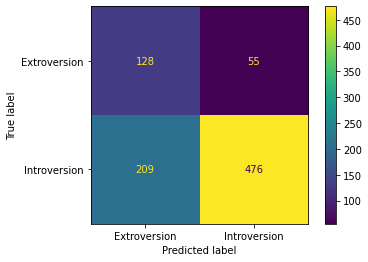

              precision    recall  f1-score   support

           0       0.38      0.70      0.49       183
           1       0.90      0.69      0.78       685

    accuracy                           0.70       868
   macro avg       0.64      0.70      0.64       868
weighted avg       0.79      0.70      0.72       868

0.6971720314307367


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score


IE_confusion = confusion_matrix(IE_Test_Y, IE_predictions)
IE_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = IE_confusion, display_labels = ['Extroversion', 'Introversion'])
IE_cm_display.plot()
plt.show()
print(classification_report(IE_Test_Y, IE_predictions))
accuracyIE= balanced_accuracy_score(IE_Test_Y, IE_predictions)
print("Balanced Accuracy for Introversion (I) / Extroversion (E): ",accuracyIE, "\n")
print("\n")

NS

Classification Report for Intuition (N)/ Sensing (S): 
 
              precision    recall  f1-score   support

           0       0.16      0.43      0.24       128
           1       0.86      0.62      0.72       740

    accuracy                           0.59       868
   macro avg       0.51      0.52      0.48       868
weighted avg       0.76      0.59      0.65       868

Accuracy for Intuition (N)/ Sensing (S):  0.5243032094594595 





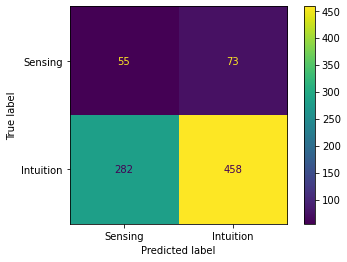

In [ ]:
#Classification Report for Intuition (N)/ Sensing (S)
print("Classification Report for Intuition (N)/ Sensing (S): \n ")
print(classification_report(NS_Test_Y, NS_predictions))
accuracyNS=balanced_accuracy_score(NS_Test_Y,NS_predictions)
print("Balanced Accuracy for Intuition (N)/ Sensing (S): ",accuracyNS, "\n")
print("\n")

#CAonfusion matrix
NS_confusion = confusion_matrix(NS_Test_Y, NS_predictions)
NS_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = NS_confusion, display_labels = ['Sensing', 'Intuition'])
NS_cm_display.plot()
plt.show()

TF

Classification Report for Thinking (T)/ Feeling(F): 
 
              precision    recall  f1-score   support

           0       0.57      0.40      0.47       478
           1       0.46      0.63      0.53       390

    accuracy                           0.50       868
   macro avg       0.52      0.51      0.50       868
weighted avg       0.52      0.50      0.50       868

Accuracy for Thinking (T)/ Feeling(F):  0.5149393841862461 





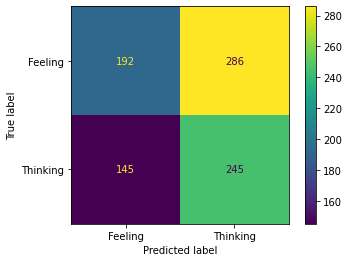

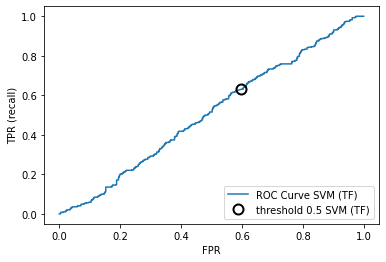

In [ ]:
#Classification Report for Thinking (T)/ Feeling(F)
print("Classification Report for Thinking (T)/ Feeling(F): \n ")
print(classification_report(TF_Test_Y, TF_predictions))
accuracyTF=balanced_accuracy_score(TF_Test_Y,TF_predictions)
print("Balanced Accuracy for Thinking (T)/ Feeling(F): ",accuracyTF, "\n")
print("\n")

#CAonfusion matrix
TF_confusion = confusion_matrix(TF_Test_Y, TF_predictions)
TF_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = TF_confusion, display_labels = ['Feeling', 'Thinking'])
TF_cm_display.plot()
plt.show()


JP

Classification Report for Judging (J)/ Perceiving (P): 
 
              precision    recall  f1-score   support

           0       0.60      0.40      0.48       502
           1       0.44      0.63      0.52       366

    accuracy                           0.50       868
   macro avg       0.52      0.52      0.50       868
weighted avg       0.53      0.50      0.50       868

Accuracy for Judging (J)/ Perceiving (P):  0.5191311257701434 





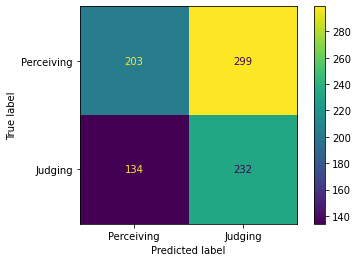

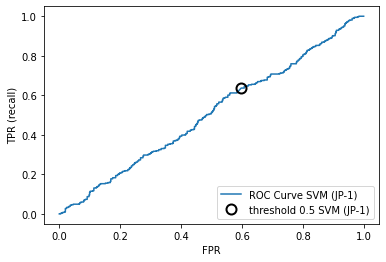

In [ ]:
#Classification Report for Judging (J)/ Perceiving (P)
print("Classification Report for Judging (J)/ Perceiving (P): \n ")
print(classification_report(JP_Test_Y, JP_predictions))
accuracyJP=balanced_accuracy_score(JP_Test_Y,JP_predictions)
print("Balanced Accuracy for Judging (J)/ Perceiving (P): ",accuracyJP, "\n")
print("\n")

#CAonfusion matrix
JP_confusion = confusion_matrix(JP_Test_Y, JP_predictions)
JP_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = JP_confusion, display_labels = ['Perceiving', 'Judging'])
JP_cm_display.plot()
plt.show()